<a href="https://colab.research.google.com/github/ShriramGithub7/EVA8_S5_Batch_Normalization_-_Regularization/blob/main/EVA8_Session_5_Batch_Normalization_%26_Regularization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount Google Drive, load mymodel.py file and create model object

In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Load the model.py file

In [5]:
!cp /content/drive/MyDrive/mymodel.py .


Create model object

In [6]:
import mymodel
model = mymodel.Net()

# Import libraries

In [7]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from __future__ import print_function

# Find mean and std deviation of the data

In [8]:
testing_transofrms = transforms.Compose([transforms.ToTensor()])
exp= datasets.MNIST('.data/', train=True, download=True, transform=testing_transofrms)
exp_data = exp.train_data
exp_data=exp.transform(exp_data.numpy())


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting .data/MNIST/raw/train-images-idx3-ubyte.gz to .data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting .data/MNIST/raw/train-labels-idx1-ubyte.gz to .data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting .data/MNIST/raw/t10k-images-idx3-ubyte.gz to .data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting .data/MNIST/raw/t10k-labels-idx1-ubyte.gz to .data/MNIST/raw



/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


In [9]:
print('shape - ', exp_data.shape)
print('size - ', exp_data.size())
print('min - ', exp_data.min())
print('max - ', exp_data.max())
print('mean - ', exp_data.mean())
print('std - ', exp_data.std())
print('var - ', exp_data.var())

shape -  torch.Size([28, 60000, 28])
size -  torch.Size([28, 60000, 28])
min -  tensor(0.)
max -  tensor(1.)
mean -  tensor(0.1307)
std -  tensor(0.3081)
var -  tensor(0.0949)


# Data transformation

In [10]:
#training data transormation

train_transforms = transforms.Compose([transforms.ToTensor(),
                                       transforms.Normalize((0.1307), (0.3081)),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(255,))
                                      ])

#testing data transformation
test_transforms = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize((0.1307), (0.3081))])

# Load data, split it in train/test and apply transform 

In [11]:
train = datasets.MNIST('.data/', train=True, download = True, transform=train_transforms)
test = datasets.MNIST('.data/', train=False, download = True, transform=test_transforms)

# Dataloader arguments and Train/Test Dataloaders

In [12]:
from torch.utils.data import dataloader
SEED = 1

cuda = torch.cuda.is_available()
print("CUDA available - ", cuda)

torch.manual_seed(SEED)

if cuda:
  torch.cuda.manual_seed(SEED)

dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

train_loader=torch.utils.data.DataLoader(train, **dataloader_args)

test_loader=torch.utils.data.DataLoader(test, **dataloader_args)


CUDA available -  True


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# View few images

torch.Size([128, 1, 28, 28])
torch.Size([128])


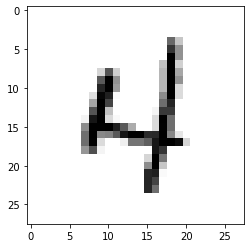

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

plt.imshow(images[0].numpy().squeeze(),cmap='gray_r')

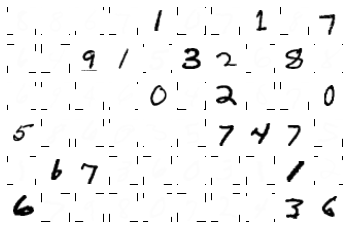

In [14]:
figure = plt.figure()
num_of_images=60
for index in range (1, num_of_images+1):
  plt.subplot(6, 10, index)
  plt.axis('off')
  plt.imshow(images[index].numpy().squeeze(),cmap='gray_r')



In [15]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cuda


# Training and Testing - Group Normalization

In [16]:
model = mymodel.Net()

In [60]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy

train_losses_group = []
test_losses_group = []
train_acc_group = []
test_acc_group = []
type_of_norm = 'gn'

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
  
    # Predict
    y_pred = model(data, type_of_norm)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses_group.append(loss.item())

    # Backpropagation
    loss.backward()
    optimizer.step()

    pred = y_pred.argmax(dim=1, keepdim=True)  
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc_group.append(100*correct/processed)

def test(model, device, test_loader, print_misclassified):
    model.eval()
    test_loss = 0
    correct = 0
    misclassified_groupNorm = []
    print_misclassified = print_misclassified
       
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data, type_of_norm)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

            # Identify misclassified images
            incorrect = pred.ne(target.view_as(pred))
            misclassified_groupNorm.extend(data[incorrect])
            
            

    test_loss /= len(test_loader.dataset)
    test_losses_group.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc_group.append(100. * correct / len(test_loader.dataset))
 
    counter = 1
    if print_misclassified:
      #fig, axs = plt.subplots(2,5, figsize=(10, 5))

      import matplotlib.pyplot as plt

      # Determine the number of rows and columns for the subplots
      rows = 2
      cols = 5

      # Use plt.subplots to create the subplots
      fig, axs = plt.subplots(rows, cols, figsize=(10, 5))
      axs = axs.ravel()

      # Plot the misclassified images in the subplots
      for i, image in enumerate(misclassified_groupNorm[:10]):
          axs[i].imshow(image.squeeze().cpu().numpy(), cmap='gray_r')
          axs[i].set_title(f"True label: {target[i].item()}", fontweight='bold')

      # Remove unused subplots
      for i in range(10, rows * cols):
          fig.delaxes(axs[i])
      
      plt.suptitle("Misclassified Images - GroupNorm", fontsize=15, fontweight='bold')

      # Show the plot
      plt.show()

  

# Train the model for Group Normalization and plot misclassified images


epoch:  0


Loss=0.5875850319862366 Batch_id=468 Accuracy=51.57: 100%|██████████| 469/469 [00:29<00:00, 15.85it/s]



Test set: Average loss: 0.2924, Accuracy: 9370/10000 (93.70%)

epoch:  1


Loss=0.2086551934480667 Batch_id=468 Accuracy=93.33: 100%|██████████| 469/469 [00:30<00:00, 15.58it/s]



Test set: Average loss: 0.0962, Accuracy: 9738/10000 (97.38%)

epoch:  2


Loss=0.11023662239313126 Batch_id=468 Accuracy=96.20: 100%|██████████| 469/469 [00:29<00:00, 15.83it/s]



Test set: Average loss: 0.0588, Accuracy: 9824/10000 (98.24%)

epoch:  3


Loss=0.06125197187066078 Batch_id=468 Accuracy=96.94: 100%|██████████| 469/469 [00:29<00:00, 15.66it/s]



Test set: Average loss: 0.0495, Accuracy: 9857/10000 (98.57%)

epoch:  4


Loss=0.07649307698011398 Batch_id=468 Accuracy=97.79: 100%|██████████| 469/469 [00:30<00:00, 15.17it/s]



Test set: Average loss: 0.0412, Accuracy: 9869/10000 (98.69%)

epoch:  5


Loss=0.04712502658367157 Batch_id=468 Accuracy=97.83: 100%|██████████| 469/469 [00:29<00:00, 15.90it/s]



Test set: Average loss: 0.0409, Accuracy: 9873/10000 (98.73%)

epoch:  6


Loss=0.09168856590986252 Batch_id=468 Accuracy=97.91: 100%|██████████| 469/469 [00:29<00:00, 16.03it/s]



Test set: Average loss: 0.0408, Accuracy: 9876/10000 (98.76%)

epoch:  7


Loss=0.027523353695869446 Batch_id=468 Accuracy=97.96: 100%|██████████| 469/469 [00:29<00:00, 15.95it/s]



Test set: Average loss: 0.0393, Accuracy: 9876/10000 (98.76%)

epoch:  8


Loss=0.03596023470163345 Batch_id=468 Accuracy=98.09: 100%|██████████| 469/469 [00:29<00:00, 16.17it/s]



Test set: Average loss: 0.0383, Accuracy: 9889/10000 (98.89%)

epoch:  9


Loss=0.04327812418341637 Batch_id=468 Accuracy=98.11: 100%|██████████| 469/469 [00:29<00:00, 16.13it/s]



Test set: Average loss: 0.0381, Accuracy: 9893/10000 (98.93%)

epoch:  10


Loss=0.06724462658166885 Batch_id=468 Accuracy=98.05: 100%|██████████| 469/469 [00:30<00:00, 15.47it/s]



Test set: Average loss: 0.0385, Accuracy: 9883/10000 (98.83%)

epoch:  11


Loss=0.02557257004082203 Batch_id=468 Accuracy=98.02: 100%|██████████| 469/469 [00:29<00:00, 15.95it/s]



Test set: Average loss: 0.0382, Accuracy: 9885/10000 (98.85%)

epoch:  12


Loss=0.033703189343214035 Batch_id=468 Accuracy=98.09: 100%|██████████| 469/469 [00:28<00:00, 16.18it/s]



Test set: Average loss: 0.0381, Accuracy: 9886/10000 (98.86%)

epoch:  13


Loss=0.03469717875123024 Batch_id=468 Accuracy=98.07: 100%|██████████| 469/469 [00:29<00:00, 16.17it/s]



Test set: Average loss: 0.0381, Accuracy: 9889/10000 (98.89%)

epoch:  14


Loss=0.026136944070458412 Batch_id=468 Accuracy=98.10: 100%|██████████| 469/469 [00:29<00:00, 16.15it/s]



Test set: Average loss: 0.0381, Accuracy: 9887/10000 (98.87%)

epoch:  15


Loss=0.051361456513404846 Batch_id=468 Accuracy=98.08: 100%|██████████| 469/469 [00:28<00:00, 16.33it/s]



Test set: Average loss: 0.0381, Accuracy: 9888/10000 (98.88%)

epoch:  16


Loss=0.0338248610496521 Batch_id=468 Accuracy=98.08: 100%|██████████| 469/469 [00:29<00:00, 16.01it/s]



Test set: Average loss: 0.0381, Accuracy: 9888/10000 (98.88%)

epoch:  17


Loss=0.05954792723059654 Batch_id=468 Accuracy=98.14: 100%|██████████| 469/469 [00:29<00:00, 16.13it/s]



Test set: Average loss: 0.0381, Accuracy: 9888/10000 (98.88%)

epoch:  18


Loss=0.02762446738779545 Batch_id=468 Accuracy=98.09: 100%|██████████| 469/469 [00:28<00:00, 16.40it/s]



Test set: Average loss: 0.0381, Accuracy: 9890/10000 (98.90%)

epoch:  19


Loss=0.05804898217320442 Batch_id=468 Accuracy=98.11: 100%|██████████| 469/469 [00:29<00:00, 15.97it/s]



Test set: Average loss: 0.0381, Accuracy: 9888/10000 (98.88%)



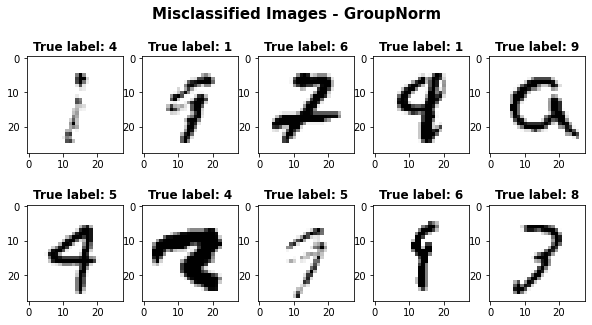

In [61]:
from torch.optim.lr_scheduler import StepLR

model =  mymodel.Net().to(device)
#model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=4, gamma=0.1)

EPOCHS = 20
print_misclassified = False

for epoch in range(EPOCHS):
    print('epoch: ', epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    
    if epoch == EPOCHS - 1:
      print_misclassified = True

    test(model, device, test_loader, print_misclassified)
    


# Training and Testing - Layer Normalization

In [63]:
from tqdm import tqdm
import matplotlib.pyplot as plt

train_losses_layer = []
test_losses_layer = []
train_acc_layer = []
test_acc_layer = []
type_of_norm = 'ln'

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
  
    # Predict
    y_pred = model(data, type_of_norm)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses_layer.append(loss.item())

    # Backpropagation
    loss.backward()
    optimizer.step()

    pred = y_pred.argmax(dim=1, keepdim=True)  
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc_layer.append(100*correct/processed)

def test(model, device, test_loader, print_misclassified):
    model.eval()
    test_loss = 0
    correct = 0
    misclassified_layerNorm = []
    print_misclassified = print_misclassified
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data, type_of_norm)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

            # Identify misclassified images
            incorrect = pred.ne(target.view_as(pred))
            misclassified_layerNorm.extend(data[incorrect])

    test_loss /= len(test_loader.dataset)
    test_losses_layer.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc_layer.append(100. * correct / len(test_loader.dataset))


    counter = 1
    if print_misclassified:

      # Determine the number of rows and columns for the subplots
      rows = 2
      cols = 5

      # Use plt.subplots to create the subplots
      fig, axs = plt.subplots(rows, cols, figsize=(10, 5))
      axs = axs.ravel()

      # Plot the misclassified images in the subplots
      for i, image in enumerate(misclassified_layerNorm[:10]):
          axs[i].imshow(image.squeeze().cpu().numpy(), cmap='gray_r')
          axs[i].set_title(f"True label: {target[i].item()}", fontweight='bold')

      # Remove unused subplots
      for i in range(10, rows * cols):
          fig.delaxes(axs[i])
      
      plt.suptitle("Misclassified Images - LayerNorm", fontsize=15, fontweight='bold')

      # Show the plot
      plt.show()



# Train the model for Layer Normalization


EPOCH: 0


Loss=1.233934760093689 Batch_id=468 Accuracy=28.61: 100%|██████████| 469/469 [00:30<00:00, 15.57it/s]



Test set: Average loss: 1.1108, Accuracy: 7011/10000 (70.11%)

EPOCH: 1


Loss=0.29633352160453796 Batch_id=468 Accuracy=84.15: 100%|██████████| 469/469 [00:30<00:00, 15.43it/s]



Test set: Average loss: 0.2063, Accuracy: 9491/10000 (94.91%)

EPOCH: 2


Loss=0.25626757740974426 Batch_id=468 Accuracy=92.57: 100%|██████████| 469/469 [00:29<00:00, 15.64it/s]



Test set: Average loss: 0.1294, Accuracy: 9634/10000 (96.34%)

EPOCH: 3


Loss=0.1705065220594406 Batch_id=468 Accuracy=93.89: 100%|██████████| 469/469 [00:30<00:00, 15.62it/s]



Test set: Average loss: 0.1141, Accuracy: 9690/10000 (96.90%)

EPOCH: 4


Loss=0.13243313133716583 Batch_id=468 Accuracy=95.26: 100%|██████████| 469/469 [00:29<00:00, 15.72it/s]



Test set: Average loss: 0.0835, Accuracy: 9770/10000 (97.70%)

EPOCH: 5


Loss=0.1129646822810173 Batch_id=468 Accuracy=95.73: 100%|██████████| 469/469 [00:30<00:00, 15.59it/s]



Test set: Average loss: 0.0815, Accuracy: 9767/10000 (97.67%)

EPOCH: 6


Loss=0.17210565507411957 Batch_id=468 Accuracy=95.89: 100%|██████████| 469/469 [00:31<00:00, 14.86it/s]



Test set: Average loss: 0.0787, Accuracy: 9773/10000 (97.73%)

EPOCH: 7


Loss=0.07107897847890854 Batch_id=468 Accuracy=95.88: 100%|██████████| 469/469 [00:30<00:00, 15.51it/s]



Test set: Average loss: 0.0777, Accuracy: 9780/10000 (97.80%)

EPOCH: 8


Loss=0.06816437840461731 Batch_id=468 Accuracy=96.05: 100%|██████████| 469/469 [00:30<00:00, 15.26it/s]



Test set: Average loss: 0.0761, Accuracy: 9788/10000 (97.88%)

EPOCH: 9


Loss=0.1386401206254959 Batch_id=468 Accuracy=96.16: 100%|██████████| 469/469 [00:30<00:00, 15.42it/s]



Test set: Average loss: 0.0755, Accuracy: 9792/10000 (97.92%)

EPOCH: 10


Loss=0.16082574427127838 Batch_id=468 Accuracy=96.17: 100%|██████████| 469/469 [00:30<00:00, 15.27it/s]



Test set: Average loss: 0.0760, Accuracy: 9789/10000 (97.89%)

EPOCH: 11


Loss=0.24626557528972626 Batch_id=468 Accuracy=96.13: 100%|██████████| 469/469 [00:30<00:00, 15.39it/s]



Test set: Average loss: 0.0754, Accuracy: 9797/10000 (97.97%)

EPOCH: 12


Loss=0.08223117142915726 Batch_id=468 Accuracy=96.09: 100%|██████████| 469/469 [00:30<00:00, 15.53it/s]



Test set: Average loss: 0.0755, Accuracy: 9798/10000 (97.98%)

EPOCH: 13


Loss=0.0711577832698822 Batch_id=468 Accuracy=96.09: 100%|██████████| 469/469 [00:30<00:00, 15.41it/s]



Test set: Average loss: 0.0755, Accuracy: 9795/10000 (97.95%)

EPOCH: 14


Loss=0.21252544224262238 Batch_id=468 Accuracy=96.13: 100%|██████████| 469/469 [00:30<00:00, 15.30it/s]



Test set: Average loss: 0.0755, Accuracy: 9797/10000 (97.97%)

EPOCH: 15


Loss=0.10798297077417374 Batch_id=468 Accuracy=96.16: 100%|██████████| 469/469 [00:30<00:00, 15.26it/s]



Test set: Average loss: 0.0754, Accuracy: 9797/10000 (97.97%)

EPOCH: 16


Loss=0.07608658820390701 Batch_id=468 Accuracy=96.17: 100%|██████████| 469/469 [00:30<00:00, 15.37it/s]



Test set: Average loss: 0.0754, Accuracy: 9797/10000 (97.97%)

EPOCH: 17


Loss=0.13276176154613495 Batch_id=468 Accuracy=96.12: 100%|██████████| 469/469 [00:30<00:00, 15.63it/s]



Test set: Average loss: 0.0754, Accuracy: 9797/10000 (97.97%)

EPOCH: 18


Loss=0.1798080950975418 Batch_id=468 Accuracy=96.03: 100%|██████████| 469/469 [00:31<00:00, 14.71it/s]



Test set: Average loss: 0.0754, Accuracy: 9797/10000 (97.97%)

EPOCH: 19


Loss=0.12671446800231934 Batch_id=468 Accuracy=96.05: 100%|██████████| 469/469 [00:30<00:00, 15.48it/s]



Test set: Average loss: 0.0754, Accuracy: 9797/10000 (97.97%)



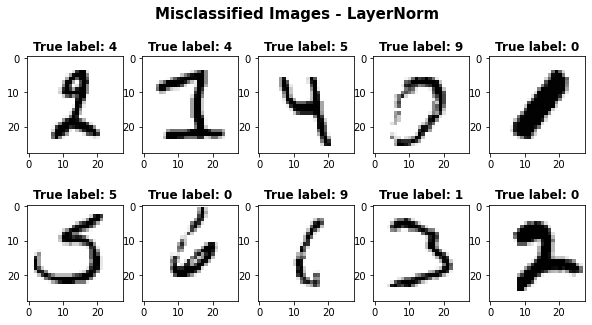

In [67]:
from torch.optim.lr_scheduler import StepLR

model =  mymodel.Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=4, gamma=0.1)

EPOCHS = 20
print_misclassified = False
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()

    if epoch == EPOCHS - 1:
      print_misclassified = True

    test(model, device, test_loader, print_misclassified)

 # Training and Testing - Batch Normalization and L1 Regularization

In [69]:
from tqdm import tqdm

train_losses_batch = []
test_losses_batch = []
train_acc_batch = []
test_acc_batch = []
type_of_norm = 'bn'

mse=nn.MSELoss()
lambda_l1 = 0.01


def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
  
    # Predict
    y_pred = model(data, type_of_norm)

    # Calculate loss
    target=target.float().unsqueeze(dim=1)

    loss = mse(y_pred, target)
    l1 = 0
    for p in model.parameters():
      l1 = l1 + p.abs().sum()
    loss = loss + lambda_l1 * l1
    

    # Backpropagation
    loss.backward()
    optimizer.step()

    pred = y_pred.argmax(dim=1, keepdim=True)  
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc_batch.append(100*correct/processed)

def test(model, device, test_loader, print_misclassified):
    model.eval()
    test_loss = 0
    correct = 0
    misclassified_batchNorm = []
    print_misclassified = print_misclassified
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data, type_of_norm)
            #test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            target=target.float().unsqueeze(dim=1)
            test_loss += mse(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

            # Identify misclassified images
            incorrect = pred.ne(target.view_as(pred))
            misclassified_batchNorm.extend(data[incorrect])

    test_loss /= len(test_loader.dataset)
    test_losses_batch.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc_batch.append(100. * correct / len(test_loader.dataset))

    counter = 1
    if print_misclassified:
      #fig, axs = plt.subplots(2,5, figsize=(10, 5))

      import matplotlib.pyplot as plt

      # Determine the number of rows and columns for the subplots
      rows = 2
      cols = 5

      # Use plt.subplots to create the subplots
      fig, axs = plt.subplots(rows, cols, figsize=(10, 5))
      axs = axs.ravel()

      # Plot the misclassified images in the subplots
      for i, image in enumerate(misclassified_batchNorm[:10]):
          axs[i].imshow(image.squeeze().cpu().numpy(), cmap='gray_r')
          axs[i].set_title(f"True label: {target[i].item()}", fontweight='bold')

      # Remove unused subplots
      for i in range(10, rows * cols):
          fig.delaxes(axs[i])
      
      plt.suptitle("Misclassified Images - BatchNorm", fontsize=15, fontweight='bold')

      # Show the plot
      plt.show()



# Train the model for Batch Normalization and L1 Regularization

EPOCH: 0


Loss=52.59210968017578 Batch_id=468 Accuracy=9.98: 100%|██████████| 469/469 [00:31<00:00, 14.89it/s]



Test set: Average loss: 0.4255, Accuracy: 980/10000 (9.80%)

EPOCH: 1


Loss=48.448341369628906 Batch_id=468 Accuracy=9.97: 100%|██████████| 469/469 [00:31<00:00, 14.84it/s]



Test set: Average loss: 0.4269, Accuracy: 980/10000 (9.80%)

EPOCH: 2


Loss=54.1327018737793 Batch_id=468 Accuracy=10.10: 100%|██████████| 469/469 [00:31<00:00, 14.76it/s]



Test set: Average loss: 0.4279, Accuracy: 980/10000 (9.80%)

EPOCH: 3


Loss=49.230499267578125 Batch_id=468 Accuracy=10.03: 100%|██████████| 469/469 [00:31<00:00, 14.93it/s]



Test set: Average loss: 0.4243, Accuracy: 1135/10000 (11.35%)

EPOCH: 4


Loss=55.647216796875 Batch_id=468 Accuracy=9.88: 100%|██████████| 469/469 [00:31<00:00, 14.95it/s]



Test set: Average loss: 0.4260, Accuracy: 980/10000 (9.80%)

EPOCH: 5


Loss=53.24620819091797 Batch_id=468 Accuracy=9.87: 100%|██████████| 469/469 [00:32<00:00, 14.58it/s]



Test set: Average loss: 0.4254, Accuracy: 980/10000 (9.80%)

EPOCH: 6


Loss=57.19384765625 Batch_id=468 Accuracy=9.87: 100%|██████████| 469/469 [00:32<00:00, 14.49it/s]



Test set: Average loss: 0.4268, Accuracy: 980/10000 (9.80%)

EPOCH: 7


Loss=55.972618103027344 Batch_id=468 Accuracy=9.87: 100%|██████████| 469/469 [00:31<00:00, 14.99it/s]



Test set: Average loss: 0.4266, Accuracy: 980/10000 (9.80%)

EPOCH: 8


Loss=52.49515151977539 Batch_id=468 Accuracy=9.87: 100%|██████████| 469/469 [00:31<00:00, 14.94it/s]



Test set: Average loss: 0.4254, Accuracy: 980/10000 (9.80%)

EPOCH: 9


Loss=48.769020080566406 Batch_id=468 Accuracy=9.87: 100%|██████████| 469/469 [00:31<00:00, 15.02it/s]



Test set: Average loss: 0.4243, Accuracy: 980/10000 (9.80%)

EPOCH: 10


Loss=56.05516052246094 Batch_id=468 Accuracy=9.87: 100%|██████████| 469/469 [00:32<00:00, 14.62it/s]



Test set: Average loss: 0.4262, Accuracy: 980/10000 (9.80%)

EPOCH: 11


Loss=49.46501922607422 Batch_id=468 Accuracy=9.87: 100%|██████████| 469/469 [00:31<00:00, 14.96it/s]



Test set: Average loss: 0.4255, Accuracy: 980/10000 (9.80%)

EPOCH: 12


Loss=64.20742797851562 Batch_id=468 Accuracy=9.87: 100%|██████████| 469/469 [00:33<00:00, 14.01it/s]



Test set: Average loss: 0.4266, Accuracy: 980/10000 (9.80%)

EPOCH: 13


Loss=55.5506706237793 Batch_id=468 Accuracy=9.87: 100%|██████████| 469/469 [00:31<00:00, 14.86it/s]



Test set: Average loss: 0.4252, Accuracy: 980/10000 (9.80%)

EPOCH: 14


Loss=57.089027404785156 Batch_id=468 Accuracy=9.87: 100%|██████████| 469/469 [00:31<00:00, 14.75it/s]



Test set: Average loss: 0.4256, Accuracy: 980/10000 (9.80%)

EPOCH: 15


Loss=59.67701721191406 Batch_id=468 Accuracy=9.87: 100%|██████████| 469/469 [00:32<00:00, 14.49it/s]



Test set: Average loss: 0.4252, Accuracy: 980/10000 (9.80%)

EPOCH: 16


Loss=52.54081344604492 Batch_id=468 Accuracy=9.87: 100%|██████████| 469/469 [00:32<00:00, 14.55it/s]



Test set: Average loss: 0.4243, Accuracy: 980/10000 (9.80%)

EPOCH: 17


Loss=50.91938781738281 Batch_id=468 Accuracy=9.87: 100%|██████████| 469/469 [00:31<00:00, 14.73it/s]



Test set: Average loss: 0.4262, Accuracy: 980/10000 (9.80%)

EPOCH: 18


Loss=56.14275360107422 Batch_id=468 Accuracy=9.87: 100%|██████████| 469/469 [00:33<00:00, 13.86it/s]



Test set: Average loss: 0.4253, Accuracy: 980/10000 (9.80%)

EPOCH: 19


Loss=60.43550109863281 Batch_id=468 Accuracy=9.87: 100%|██████████| 469/469 [00:31<00:00, 14.81it/s]



Test set: Average loss: 0.4250, Accuracy: 980/10000 (9.80%)



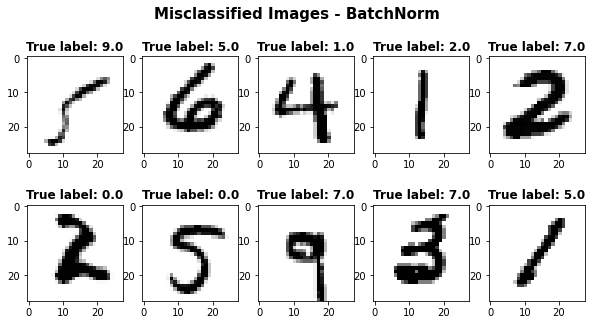

In [72]:
from torch.optim.lr_scheduler import StepLR

model =  mymodel.Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=4, gamma=0.1)

EPOCHS = 20
print_misclassified = False
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()

    if epoch == EPOCHS - 1:
      print_misclassified = True

    test(model, device, test_loader, print_misclassified)

# Plot graphs

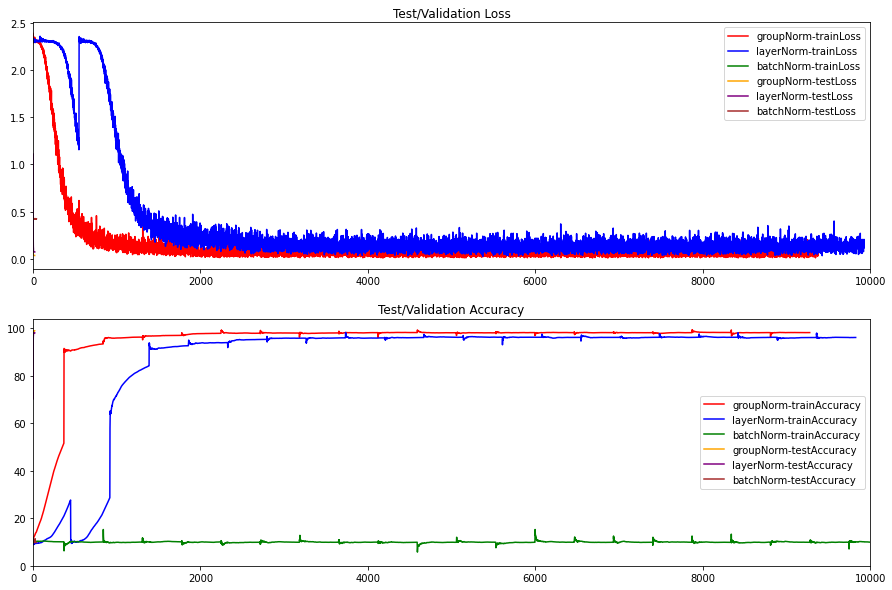

In [74]:
fig, axs = plt.subplots(2,1,figsize=(15,10))
axs[0].set_xlim([0, 10000])
axs[1].set_xlim([0, 10000])

axs[0].plot(train_losses_group, color='red', label='groupNorm-trainLoss')
axs[0].plot(train_losses_layer, color='blue', label='layerNorm-trainLoss')
axs[0].plot(train_losses_batch, color='green', label='batchNorm-trainLoss')

axs[0].plot(test_losses_group, color='orange', label='groupNorm-testLoss')
axs[0].plot(test_losses_layer, color='purple', label='layerNorm-testLoss')
axs[0].plot(test_losses_batch, color='brown', label='batchNorm-testLoss')
axs[0].set_title("Test/Validation Loss")
axs[0].legend()

axs[1].plot(train_acc_group[100:], color='red', label='groupNorm-trainAccuracy')
axs[1].plot(train_acc_layer[100:], color='blue', label='layerNorm-trainAccuracy')
axs[1].plot(train_acc_batch[100:], color='green', label='batchNorm-trainAccuracy')

axs[1].plot(test_acc_group, color='orange', label='groupNorm-testAccuracy')
axs[1].plot(test_acc_layer, color='purple', label='layerNorm-testAccuracy')
axs[1].plot(test_acc_batch, color='brown', label='batchNorm-testAccuracy')
axs[1].set_title("Test/Validation Accuracy")
axs[1].legend()
